## import library

In [67]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats

## Import dataset

In [4]:
n_features = 300
features = [f'f_{i}' for i in range(n_features)]
train = pd.read_pickle(r"C:\Users\USER\Desktop\ubiquant-market-prediction\train.pkl")
train.head()

,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,f_6,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0.0,1.0,-0.300781,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,0.965623,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0.0,2.0,-0.231079,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,1.428127,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0.0,6.0,0.568848,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,0.979656,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0.0,7.0,-1.064453,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,0.778096,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0.0,8.0,-0.531738,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,-0.946789,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [5]:
investment_id = train.pop("investment_id")
investment_id.head()

print(investment_id)

_ = train.pop("time_id")

y = train.pop("target")
y.head()

0             1.0
1             2.0
2             6.0
3             7.0
4             8.0
            ...  
3141405    3768.0
3141406    3768.0
3141407    3770.0
3141408    3772.0
3141409    3772.0
Name: investment_id, Length: 3141410, dtype: float16


0   -0.300781
1   -0.231079
2    0.568848
3   -1.064453
4   -0.531738
Name: target, dtype: float16

## custom loss function (ccc)

In [71]:
def custom_loss(pred_y, true_y):
    pred_y = tf.cast(pred_y,tf.float32)
    true_y = tf.cast(true_y,tf.float32)

    pred_mean = tf.cast(tf.math.reduce_mean(pred_y),tf.float32)
    true_mean = tf.cast(tf.math.reduce_mean(true_y),tf.float32)

    pred_std = tf.cast(tf.math.reduce_std(pred_y),tf.float32)
    true_std = tf.cast(tf.math.reduce_std(true_y),tf.float32)

    corr_ = tf.math.reduce_sum((pred_y-pred_mean)*(true_y-true_mean))/tf.cast((len(pred_y)-1),tf.float32)
    ccc = (2*corr_*pred_std*true_std)/(pred_std**2+true_std**2+(pred_mean-true_mean)**2)

    mse = tf.math.reduce_sum((pred_y-true_y)**2)/tf.cast((len(pred_y)-1),tf.float32)
    return 1- ccc + mse


## Create a IntegerLookup layer for investment_id input

In [7]:
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
print(investment_id_size)
investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
## integerlookup은 
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids})) 
## 일부 전처리 레이어는 훈련데이터의 셈플을 기반으로 계산해야하는 내부 상태가 있음.
## 이러한 전처리 레이어는 '훈련불가능'하기 때문에 훈련중 설정이 되지않음. -> 훈련전에 설정해야함
## 이 단계를 적응(adaptation)이라고 함.


2789


In [8]:
import tensorflow as tf

def preprocess(X, y):
    return X, y
def make_dataset(feature, investment_id, y, batch_size=1024, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(4096) ## 완벽한 셔플링을 위해서는 셔플링의 크기와 버퍼의 크기가 같아야함
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [73]:
def get_model():

    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    ## Embedding()을 사용하기 위해서는 입력 될 각 단어들은 모두 정수 인덱싱이 되어 있어야 합니다.
    # this code uses variables embedding method because one-hot encoding has many computational costs 

    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)
    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss=custom_loss, metrics=['mse', "mae", "mape", rmse])
    return model

In [74]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

Model: "model_28"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_59 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 integer_lookup (IntegerLookup)  (None, 1)           0           ['input_59[0][0]']               
                                                                                                  
 embedding_29 (Embedding)       (None, 1, 32)        89248       ['integer_lookup[29][0]']        
                                                                                                  
 reshape_29 (Reshape)           (None, 32)           0           ['embedding_29[0][0]']           
                                                                                           

C:\Users\USER\Anaconda3\envs\tw_tf\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Epoch 1/30
2455/2455 [==============================] - 97s 39ms/step - loss: 0.8765 - mse: 3357.5378 - mae: 17.3588 - mape: 62604388.0000 - rmse: 57.9443 - val_loss: 0.8417 - val_mse: 769.4019 - val_mae: 8.5042 - val_mape: 35656980.0000 - val_rmse: 27.7381
Epoch 2/30
2455/2455 [==============================] - 90s 37ms/step - loss: 0.7701 - mse: 3668.8113 - mae: 27.1438 - mape: 75503816.0000 - rmse: 60.5707 - val_loss: 0.8357 - val_mse: 1874.1736 - val_mae: 14.1248 - val_mape: 49803852.0000 - val_rmse: 43.2917
Epoch 3/30
2455/2455 [==============================] - 89s 36ms/step - loss: 0.7599 - mse: 6770.6816 - mae: 36.0390 - mape: 91470888.0000 - rmse: 82.2841 - val_loss: 0.8345 - val_mse: 4740.4180 - val_mae: 22.3260 - val_mape: 69676552.0000 - val_rmse: 68.8507
Epoch 4/30
2455/2455 [==============================] - 88s 36ms/step - loss: 0.7516 - mse: 17699.2520 - mae: 40.8182 - mape: 117711400.0000 - rmse: 133.0385 - val_loss: 0.8412 - val_mse: 5439.9653 - val_mae: 22.2283 - val

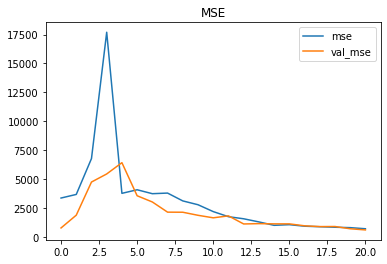

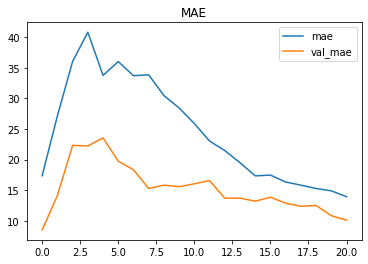

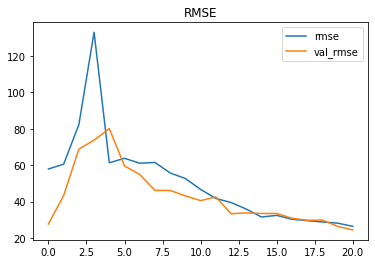

Epoch 1/30
2455/2455 [==============================] - 90s 36ms/step - loss: 0.8787 - mse: 2921.5513 - mae: 16.9778 - mape: 60814932.0000 - rmse: 54.0514 - val_loss: 0.8364 - val_mse: 595.3048 - val_mae: 8.3572 - val_mape: 35229124.0000 - val_rmse: 24.3989
Epoch 2/30
2455/2455 [==============================] - 88s 36ms/step - loss: 0.7741 - mse: 2888.9563 - mae: 24.6283 - mape: 58923476.0000 - rmse: 53.7490 - val_loss: 0.8319 - val_mse: 1818.4430 - val_mae: 14.6300 - val_mape: 57515668.0000 - val_rmse: 42.6432
Epoch 3/30
2455/2455 [==============================] - 86s 35ms/step - loss: 0.7606 - mse: 6639.2471 - mae: 36.0246 - mape: 87463824.0000 - rmse: 81.4816 - val_loss: 0.8253 - val_mse: 2059.9993 - val_mae: 15.5853 - val_mape: 53723680.0000 - val_rmse: 45.3872
Epoch 4/30
2455/2455 [==============================] - 86s 35ms/step - loss: 0.7507 - mse: 10265.8516 - mae: 44.3422 - mape: 87386128.0000 - rmse: 101.3205 - val_loss: 0.8235 - val_mse: 2246.3499 - val_mae: 15.9531 - val_

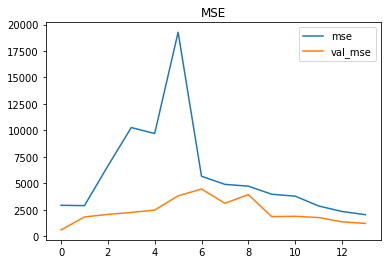

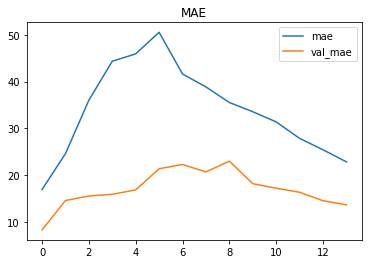

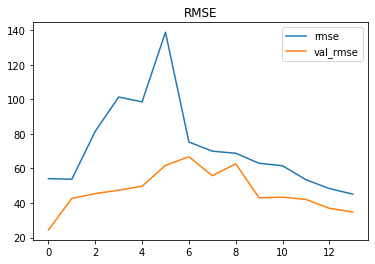

Epoch 1/30
2455/2455 [==============================] - 88s 35ms/step - loss: 0.8820 - mse: 2143.0537 - mae: 15.9288 - mape: 50386620.0000 - rmse: 46.2931 - val_loss: 0.8312 - val_mse: 394.1588 - val_mae: 8.3266 - val_mape: 31967406.0000 - val_rmse: 19.8534
Epoch 2/30
2455/2455 [==============================] - 93s 38ms/step - loss: 0.7700 - mse: 2644.2441 - mae: 24.2397 - mape: 61199672.0000 - rmse: 51.4222 - val_loss: 0.8261 - val_mse: 1747.1619 - val_mae: 15.2723 - val_mape: 65076916.0000 - val_rmse: 41.7991
Epoch 3/30
2455/2455 [==============================] - 87s 35ms/step - loss: 0.7603 - mse: 6800.6685 - mae: 36.8402 - mape: 81286528.0000 - rmse: 82.4662 - val_loss: 0.8165 - val_mse: 2922.6504 - val_mae: 21.8961 - val_mape: 74253376.0000 - val_rmse: 54.0615
Epoch 4/30
2455/2455 [==============================] - 87s 36ms/step - loss: 0.7505 - mse: 6485.1733 - mae: 38.0595 - mape: 87500248.0000 - rmse: 80.5306 - val_loss: 0.8130 - val_mse: 1842.4729 - val_mae: 16.8666 - val_ma

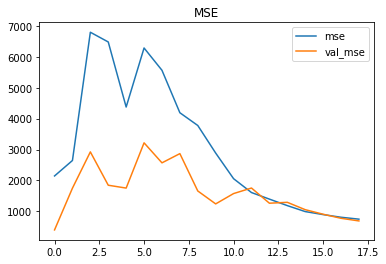

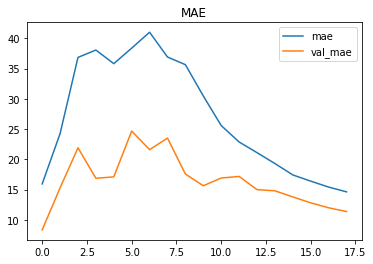

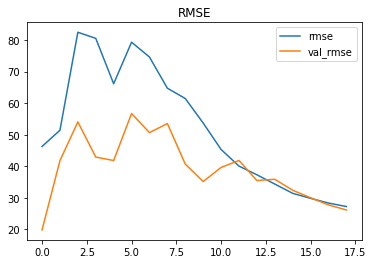

Epoch 1/30
2455/2455 [==============================] - 99s 40ms/step - loss: 0.8821 - mse: 5843.4546 - mae: 22.5935 - mape: 61457692.0000 - rmse: 76.4425 - val_loss: 0.8298 - val_mse: 440.3242 - val_mae: 9.2799 - val_mape: 30031246.0000 - val_rmse: 20.9839
Epoch 2/30
2455/2455 [==============================] - 92s 37ms/step - loss: 0.7760 - mse: 9947.6631 - mae: 36.5788 - mape: 83364720.0000 - rmse: 99.7380 - val_loss: 0.8182 - val_mse: 1160.6091 - val_mae: 13.3198 - val_mape: 51434420.0000 - val_rmse: 34.0677
Epoch 3/30
2453/2455 [============================>.] - ETA: 0s - loss: 0.7566 - mse: 6253.7729 - mae: 34.4099 - mape: 76688944.0000 - rmse: 79.0808

In [75]:
%%time
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(train, investment_id)):
    ## 
    X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]

    investment_id_train = investment_id[train_indices]

    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]

    investment_id_val = investment_id[valid_indices]

    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    
    model = get_model()
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_ds, epochs=30, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
    
    model = keras.models.load_model(f"model_{index}",compile=False) ## this notebook uses k-fold cross validation and the number of this model is 5
    models.append(model)
    
    pearson_score = stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    plt.title("MSE")
    plt.show()
    pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    plt.title("MAE")
    plt.show()
    pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
    plt.title("RMSE")
    plt.show()
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    gc.collect()
    #break

## submission

In [ ]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0
def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds
def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)

: 

In [ ]:
import ubiquant
env = ubiquant.make_env()
iter_test = env.iter_test() 
for (test_df, sample_prediction_df) in iter_test:
    ds = make_test_dataset(test_df[features], test_df["investment_id"])
    sample_prediction_df['target'] = inference(models, ds)
    env.predict(sample_prediction_df)